# Install Libraries

In [ ]:
%pip install datasets
%pip install -q git+https://github.com/huggingface/transformers.git
%pip install segment-geospatial leafmap localtileserver
%pip install -q ipyleaflet

# Import Dependencies

In [ ]:
from datasets import Dataset, load_dataset
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import torch
from PIL import Image
import io
import os
import ipyleaflet
import ipywidgets
import leafmap.leafmap as leafmap
from samgeo import SamGeo, tms_to_geotiff

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

# Testing the SamGEO Input Prompt API

We attempted to use the SamGEO [input prompt API](https://samgeo.gishub.org/examples/input_prompts/). The results were disappointing overall. The API itself seems to have been rushed out with some poor design choices: e.g. the pretrained weights must be input as a path to a directory containing a file specifically named "sam_vit_l_0b3195.pth" or two other options, inputting the weights file itself throws an error. This makes little sense.

Getting the map to run on Colab was difficult and generally inconsistent. Specifying the backend as ipyleaflet by importing leafmap.leafmap (although this should be the default case) helps the issue, but the same code runs inconsistently between sessions. This is especially odd given that leafmap generally runs decently on Colab. The ML2 code runs consistently, for instance, so it seems to be an issue specifically with the SamGEO Input Prompt API.

When we finally managed to get the predictions to work, despite using the same weights we trained on the generic SAM model, the SamGEO model output masks that were significantly less accurate, and trying to make these masks work with the map feature yielded a variety of absolutely incomprehensible error messages (see more below).

# Load in and Prepare Dataset

In [ ]:
sidewalk_test = load_dataset("back2classroom/sidewalks", split='val', streaming=True)

In [ ]:
test_images = []
test_labels = []
# save tfw files, convert from bytes to list of floats
test_tfws = []

# Loop through the streamed dataset and collect images and masks
for sample in sidewalk_test:
    test_images.append(sample['tif'])
    test_labels.append(sample['label_tif'])
    # convert tfws from byte to list of floats
    tfw_string = sample['tfw'].decode('utf-8')
    tfw_data_list = [float(num) for num in tfw_string.split('\r\n') if num]
    test_tfws.append(tfw_data_list)

# Decode a JPEG byte string to a NumPy array
def decode_jpeg_to_array(jpeg_bytes):
    with io.BytesIO(jpeg_bytes) as byte_stream:
        image = Image.open(byte_stream)
        return np.array(image)

valid_indices = []
false_counter = 0

for i, mask_bytes in enumerate(test_labels):
    mask_np = decode_jpeg_to_array(mask_bytes)
    # Check if any pixel in the mask is not zero
    if np.any(mask_np != 0):
        valid_indices.append(i)
    else:
        false_counter += 1

print("Empty masks: ", false_counter)


filtered_images = [test_images[i] for i in valid_indices]
filtered_masks = [test_labels[i] for i in valid_indices]
filtered_tfws = [test_tfws[i] for i in valid_indices]

Empty masks:  9917


In [ ]:
# Sanity check
print(len(filtered_images), len(filtered_masks), len(filtered_tfws))

10082 10082 10082


In [ ]:
# Convert byte arrays to numpy arrays
def convert_to_numpy(byte_data):
    with io.BytesIO(byte_data) as byte_stream:
        image = Image.open(byte_stream)
        image_np = np.array(image)
        return image_np

def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox


dataset_dict = {
    "image": filtered_images,  # Directly use the byte data
    "label": filtered_masks,   # Directly use the byte data
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

# Check Data Loaded Correctly

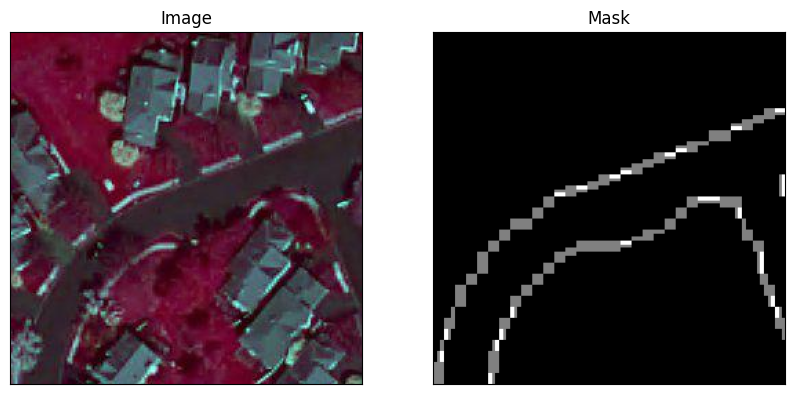

In [ ]:
img_num = random.randint(0, convert_to_numpy(filtered_images[0]).shape[0]-1)

image_np = dataset[img_num]["image"]
mask_np = dataset[img_num]["label"]

image_np = convert_to_numpy(image_np)
mask_np = convert_to_numpy(mask_np)

example_image = Image.fromarray(image_np)
example_mask = Image.fromarray(mask_np)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# Initialize SamGeo Class

Following this [tutorial](https://samgeo.gishub.org/examples/input_prompts/#initialize-sam-class), we initialized the SamGEO class using the weights we finetuned in ML3

In [ ]:
# SamGeo will look for a file specifically named sam_vit_l_0b3195.pth in this directory because this API needs work
train_model_dir = "/content/drive/MyDrive/Colab Notebooks/"

trainGeo = SamGeo(model_type="vit_h", automatic=False, sam_kwargs=None, checkpoint_dir=train_model_dir)

# Initialize Map Object

In [ ]:
m = leafmap.Map(center=filtered_tfws[15][-2:], zoom=15, height="800px")
m.add_basemap("SATELLITE")
bbox = [-122.1497, 37.6311, -122.1203, 37.6458]
image = "satellite.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=16, source="Satellite", overwrite=True)
m.add_raster(image, layer_name="Image")
m

Downloaded image 01/30
Downloaded image 02/30
Downloaded image 03/30
Downloaded image 04/30
Downloaded image 05/30
Downloaded image 06/30
Downloaded image 07/30
Downloaded image 08/30
Downloaded image 09/30
Downloaded image 10/30
Downloaded image 11/30
Downloaded image 12/30
Downloaded image 13/30
Downloaded image 14/30
Downloaded image 15/30
Downloaded image 16/30
Downloaded image 17/30
Downloaded image 18/30
Downloaded image 19/30
Downloaded image 20/30
Downloaded image 21/30
Downloaded image 22/30
Downloaded image 23/30
Downloaded image 24/30
Downloaded image 25/30
Downloaded image 26/30
Downloaded image 27/30
Downloaded image 28/30
Downloaded image 29/30
Downloaded image 30/30
Saving GeoTIFF. Please wait...
Image saved to satellite.tif


# SamGEO API Results

Here we attempted to use the SamGEO predict function to create masks using our finetuned SAM model. Attempts to integrate these masks with the map object generally led to incomprehensible errors: adding an output path led to a "cannot handle type ((1, 1), \<i8/>) error", seemingly from the API attempting to use PIL to convert the masks to an image, which we manage to trivially accomplish manually below. Adding the point_crs option, required for integrating with the map object, led to a "file not found" error. I have no idea what file this error refers to. Critically, the add_raster function only works if the crs is specified using the point_crs option in the predict function.

The only thing we could get to work was returning the masks directly from the predict function. By setting return_results to true, the predict function returns a tuple, the first element of which contains three masks, and the second an array of mask scores. Generally, the produced masks were signifcantly less accurate than those produced using the same weights with the generic SAM model. This API does not seem to allow for the same level of customization so we were forced to use the raw ouput. You can see below the best results we managed to achieve after testing a couple dozen images

In [ ]:
idx = 15
test_image = convert_to_numpy(dataset[idx]["image"])
test_mask = convert_to_numpy(dataset[idx]["label"])
mask_path = "mask1.tif"

# set the image to prep for prediction
trainGeo.set_image(test_image)
# coordinates are last two elements of tfw list, must be a list of lists
point_coords = [filtered_tfws[idx][-2:]]

# predict mask, set return_results=True to capture a tuple of (3 masks, mask scores)
masks = trainGeo.predict(point_coords, point_labels=1, return_results=True)

# Does not work with specifying CRS in predict function
#m.add_raster(masks[0][0] layer_name="Mask1", nodata=0, cmap="Blues", opacity=1)

# mask scores
print(masks[1])

[0.38203365 0.9171729  0.5551529 ]


#Display Three Masks Returned
Scores are extremely inconsistent, which makes sense without ground truth to compare the results with. Theoretically, we can input a GT mask into the predict function which I assume would correct the scores using option "mask_input=\<np array\>", but we cannot get it to work and the error messages in this API are extremely unhelpful. [Doc for reference](https://samgeo.gishub.org/samgeo/#samgeo.samgeo.SamGeo.predict). The results from this are also significantly worse than the generic SAM model in general. The following masks were actually the best results we could find using this model, and they are still worse than using the common module with the same pretrained weights.

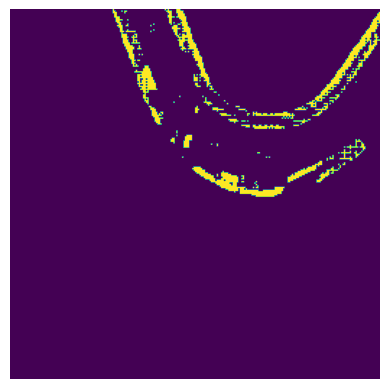

In [ ]:
image = Image.fromarray((masks[0][0].astype('uint8') * 255))

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

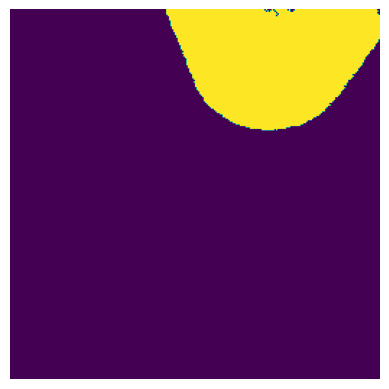

In [ ]:
image = Image.fromarray((masks[0][1].astype('uint8') * 255))

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

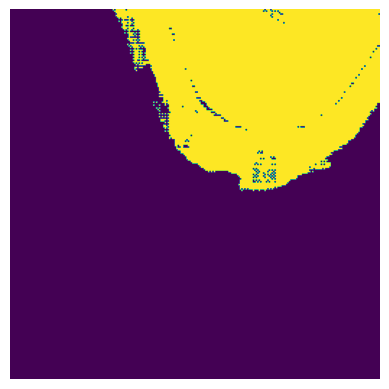

In [ ]:
image = Image.fromarray((masks[0][2].astype('uint8') * 255))

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

# Ground Truth Mask

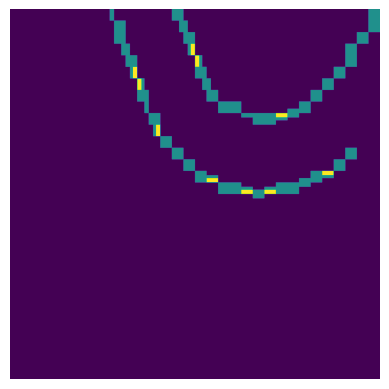

In [ ]:
plt.imshow(convert_to_numpy(dataset[idx]["label"]))
plt.axis('off')
plt.show()

# Map

 Although we did manage to get the [tutorial](https://samgeo.gishub.org/examples/input_prompts/) to run, integrating our prediction results with the map proved extremely difficult. The map does not work without inputting coordinates of the original image into the predict function, but all attempts to do so resulted in incomprehensible errors thrown by the API. Obviously, if we can't get our original images and masks to integrate with the map, we cannot even attempt to classify trees and fix occlusions using this strategy.

In [ ]:
trainGeo.show_map()

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…